In [38]:
import fenics as fn
import matplotlib.pyplot as plt
from dolfin_utils.meshconvert import meshconvert
import os
from subprocess import call

import numpy as np
import jax
import jax.numpy as jnp
from jax.example_libraries import stax, optimizers
import matplotlib.pyplot as plt
import pinns 
import datetime
import jax.scipy.optimize
import jax.flatten_util
import scipy
import scipy.optimize
import chaospy as cp



In [39]:
def curl2D(v):
    return fn.as_vector((v.dx(1),-v.dx(0)))

class FEM():
            
    def __init__(self,J0=1000.0,mu0=1.0,mur=10.0, k1=0.001, k2=1.65, k3 = 0.5, meshsize = 0.001, verb = False):
        path='./quad/'
        
        with open(path + 'quad.geo', 'r') as file:
            data = file.read()
            
        s = "meshsize=%.18f;\n"%(meshsize)
        
        s = s + data
        
        with  open(path+"tmp.geo", "w") as file:
            file.write(s)
            file.close()
        if verb: print('geo file created',flush = True)
        
        if verb:
            os.system('gmsh %stmp.geo -nt 20 -3 -o %stmp.msh -format msh2 '%(path,path))
        else:
            os.system('gmsh %stmp.geo -nt 20 -3 -o %stmp.msh -format msh2 >/dev/null 2>&1'%(path,path))
        if verb: print('mesh file created',flush=True)

        if verb:
            os.system('dolfin-convert %stmp.msh %stmp.xml'%(path,path))
        else:
            os.system('dolfin-convert %stmp.msh %stmp.xml >/dev/null 2>&1'%(path,path))
        
        if verb: print('mesh file converted in fenics format',flush=True) 

        mesh = fn.Mesh(path+'tmp.xml')
        domains = fn.MeshFunction("size_t", mesh, path+'tmp_physical_region.xml')
        boundaries = fn.MeshFunction('size_t', mesh, path+'tmp_facet_region.xml')

        self.mesh = mesh
        ncells = [  mesh.num_vertices(), mesh.num_edges(), mesh.num_faces(), mesh.num_facets(), mesh.num_cells() ]
        
        def nu_lin(az):
            return 1/(mu0*mur)
        def nonlin_nu(az):
            tmp =  k1*fn.exp(k2*fn.dot(az.dx(1),az.dx(1)))+k3
            return tmp
        
        def nu_Bauer(B):
            x = fn.dot(B,B)
            return k1*fn.exp(k2*x)+k3
        
        # Coil
        def setup_coil(mesh,subdomains):
            DG = fn.FunctionSpace(mesh,"DG",0)
            J = fn.Function(DG)
            idx = []
            for cell_no in range(len(subdomains.array())):
                subdomain_no = subdomains.array()[cell_no]
                if subdomain_no == 3:
                    idx.append(cell_no)
            J.vector()[:] = 0
            J.vector()[idx] = J0
            return J
        
    
        
        """ define function space and boundary conditions"""
        
        CG = fn.FunctionSpace(mesh, 'CG', 1) # Continuous Galerkin
        
        # Define boundary condition
        bc = fn.DirichletBC(CG, fn.Constant(0.0), boundaries,16)
        
        # Define subdomain markers and integration measure
        dx = fn.Measure('dx', domain=mesh, subdomain_data=domains)
        
        J = setup_coil(mesh, domains)
        
        class Nu(fn.UserExpression): # UserExpression instead of Expression
            def __init__(self, markers, **kwargs):
                super().__init__(**kwargs) # This part is new!
                self.markers = markers
            def eval_cell(self, values, x, cell):
                if self.markers[cell.index] == 1:
                    values[0] = 0.0   # iron
                elif self.markers[cell.index] == 2:
                    values[0] = 1/mu0      # air
                elif self.markers[cell.index] == 3:
                    values[0] = 1/mu0      # air
                else:
                    print('no such domain',self.markers[cell.index] )
                    
        nus = Nu(domains, degree=1)
        
        
        """ weak formulation """
        
        az  = fn.Function(CG)
        u  = fn.Function(CG)
        v  = fn.TestFunction(CG)
        #az = Function(CG)
        #a  = (1/mu)*dot(grad(az), grad(v))*dx
        a = fn.inner(nus*curl2D(u), curl2D(v))*dx + fn.inner(nu_lin(curl2D(u))*curl2D(u),curl2D(v))*dx(1)
        L  = J*v*dx(3)
        
        F = a - L
        # solve variational problem
        fn.solve(F == 0, u, bc)
        az = u
        self.az = az
        # function space for H- and B- field allocated on faces of elements
        W = fn.VectorFunctionSpace(mesh, fn.FiniteElement("DP", fn.triangle, 0),1)
        B = fn.project(curl2D(az), W)
        H = None# project((1/mu)*curl(az), W)
        self.B = B
        self.H = H
    
    def call_A(self,x_eval,y_eval):
        
        
        Afem = 0 * x_eval
        for i in range(x_eval.size):
            try:
                Afem[i] = self.az(x_eval[i],y_eval[i])
            except:
                Afem[i] = np.nan
        return Afem
    
    def call_B(self,x_eval,y_eval):
        
        
        Bfem = []
        for i in range(x_eval.size):
            try:
                Bfem.append(self.B(x_eval[i],y_eval[i]))
            except:
                Bfem.append([ np.nan , np.nan])
        return np.array(Bfem)
    
    def call_H(self,x_eval,y_eval):
        Hfem = []
        for i in range(x_eval.size):
            try:
                Hfem.append(self.H(x_eval[i],y_eval[i]))
            except:
                Hfem.append([ np.nan , np.nan])
        return np.array(Hfem)

In [40]:
from jax.config import config
config.update("jax_enable_x64", True)
rnd_key = jax.random.PRNGKey(1234)


gpus = jax.devices('gpu')
print('GPUs: ',gpus)


GPUs:  [GpuDevice(id=0, process_index=0), GpuDevice(id=1, process_index=0)]


In [41]:

def create_geometry(key, scale = 1):
    scale = scale
    Nt = 24                                                                
    lz = 40e-3                                                             
    Do = 72e-3                                                            
    Di = 51e-3                                                            
    hi = 13e-3                                                             
    bli = 3e-3                                                             
    Dc = 3.27640e-2                                                           
    hc = 7.55176e-3                                                           
    ri = 20e-3                                                           
    ra = 18e-3                                                           
    blc = hi-hc                                                           
    rm = (Dc*Dc+hc*hc-ri*ri)/(Dc*np.sqrt(2)+hc*np.sqrt(2)-2*ri)                 
    R = rm-ri
    O = np.array([rm/np.sqrt(2),rm/np.sqrt(2)])
    alpha1 = -np.pi*3/4       
    alpha2 = np.math.asin((hc-rm/np.sqrt(2))/R)
    alpha = np.abs(alpha2-alpha1)
    
    A = np.array([[O[0] - ri/np.sqrt(2), O[1] - ri/np.sqrt(2)], [O[0] - Dc, O[1] - hc]])
    b = np.array([[A[0,0]*ri/np.sqrt(2)+A[0,1]*ri/np.sqrt(2)],[A[1,0]*Dc+A[1,1]*hc]])
    C = np.linalg.solve(A,b)
    
    knots1 = np.array([[Do,Do * np.tan(np.pi/8)],[Do/np.sqrt(2),Do/np.sqrt(2)],[rm/np.sqrt(2),rm/np.sqrt(2)],[ri/np.sqrt(2),ri/np.sqrt(2)]])
    #knots2 = np.array([[Dc,hc],[Dc+blc,hi],[Di-bli,hi],[Di,hi-bli],[Di,0]])
    knots2 = np.array([[Di,hi-bli],[Di-bli,hi],[Dc+blc,hi],[Dc,hc]])
    knots3 = (knots1+knots2)/2
    knots3[-1,:] = C.flatten()
    knots = np.concatenate((knots1[None,...],knots3[None,...],knots2[None,...]),0)
    weights = np.ones(knots.shape[:2])
    weights[1,-1] = np.sin((np.pi-alpha)/2)
    basis2 = pinns.bspline.BSplineBasis(np.array([-1,-0.33,0.33,1]),1)
    basis1 = pinns.bspline.BSplineBasis(np.array([-1,1]),2)

    geom1 = pinns.geometry.PatchNURBS([basis1, basis2], knots, weights, key)
   
    knots2 = np.array([ [ [Dc,0],[Dc+blc,0],[Di-bli,0],[Di,0] ] , [[Dc,hc],[Dc+blc,hi],[Di-bli,hi],[Di,hi-bli]] ]) 
    knots2 = knots2[:,::-1,:]
    weights = np.ones(knots2.shape[:2])
    
    basis1 = pinns.bspline.BSplineBasis(np.linspace(-1,1,2),1)
    basis2 = pinns.bspline.BSplineBasis(np.array([-1,-0.33,0.33,1]),1)

    geom2 = pinns.geometry.PatchNURBS([basis1, basis2], knots2, weights, key)
   
    knots = np.array([ [ [0,0] , [Dc/2,0] , [Dc,0] ] , [ [ri/np.sqrt(2),ri/np.sqrt(2)] , [C[0,0],C[1,0]] , [Dc,hc] ]])
    
    basis1 = pinns.bspline.BSplineBasis(np.linspace(-1,1,2),1)
    basis2 = pinns.bspline.BSplineBasis(np.array([-1,1]),2)
    
    weights = np.ones(knots.shape[:2])
    weights[1,1] = np.sin((np.pi-alpha)/2)
    geom3 = pinns.geometry.PatchNURBS([basis1, basis2], knots, weights, key)

    knots1 = np.array([[Do,0],[Do,Do * np.tan(np.pi/8)]])
    knots2 = np.array([[Di,0],[Di,hi-bli]])
    knots3 = (knots1+knots2)/2
    knots = np.concatenate((knots1[None,...],knots3[None,...],knots2[None,...]),0)
    weights = np.ones(knots.shape[:2])

    basis2 = pinns.bspline.BSplineBasis(np.linspace(-1,1,2),1)
    basis1 = pinns.bspline.BSplineBasis(np.array([-1,1]),2)

    geom4 = pinns.geometry.PatchNURBS([basis1, basis2], knots, weights, key)
    return  geom1, geom3, geom2, geom4

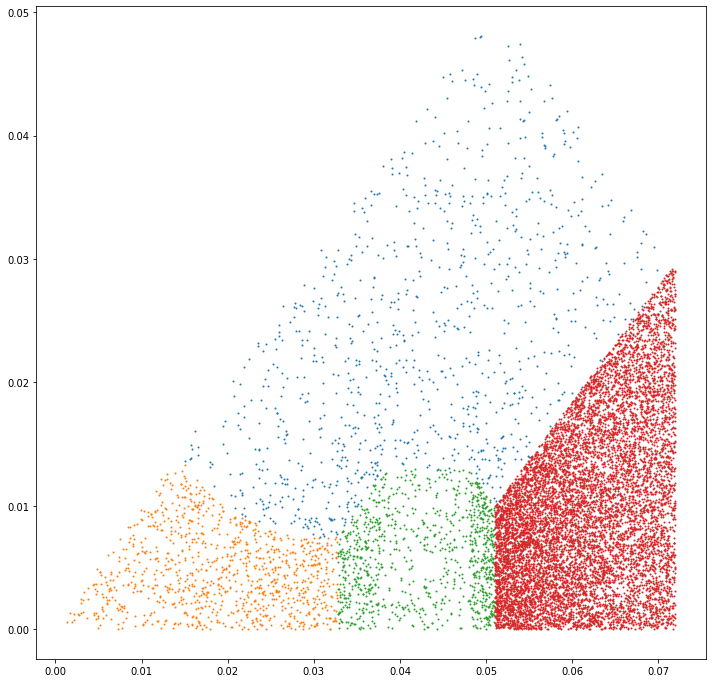

In [42]:
geom1, geom2, geom3, geom4 = create_geometry(rnd_key)

pts,_ = geom1.importance_sampling(1000)

plt.figure(figsize=(12,12))
plt.scatter(pts[:,0], pts[:,1], s = 1)

pts,_ = geom2.importance_sampling(1000)
plt.scatter(pts[:,0],pts[:,1], s = 1)

pts,_ = geom3.importance_sampling(1000)
plt.scatter(pts[:,0],pts[:,1], s = 1)

pts,_ = geom4.importance_sampling(10000)
plt.scatter(pts[:,0],pts[:,1], s = 1)
plt.show()

In [43]:
def interface_function2d(nd, endpositive, endzero, nn):

    faux = lambda x: ((x-endzero)**1/(endpositive-endzero)**1)
    if nd == 0:
        fret = lambda ws, x: (nn(ws, x[...,1][...,None]).flatten()*faux(x[...,0]))[...,None]
    else:
        fret = lambda ws, x: (nn(ws, x[...,0][...,None]).flatten()*faux(x[...,1]))[...,None]
    return fret

def jump_function2d(nd, pos_y, nn):

    faux = lambda x: jnp.abs(x-pos_y)
    if nd == 1:
        fret = lambda ws, x: (nn(ws, x[...,1][...,None]).flatten()*faux(x[...,0]))[...,None]
    else:
        fret = lambda ws, x: (nn(ws, x[...,0][...,None]).flatten()*faux(x[...,1]))[...,None]
    return fret


class Model(pinns.PINN):
    def __init__(self, rand_key):
        super().__init__()
        self.key = rand_key

        N = [32,32]
        nl = 8
        acti =  stax.elementwise(lambda x: jax.nn.leaky_relu(x)**2)
        acti1 = stax.elementwise(lambda x: jax.nn.leaky_relu(x+1)**2)
        acti2 = stax.elementwise(lambda x: jax.nn.leaky_relu(x+0.33)**2)
        acti3 = stax.elementwise(lambda x: jax.nn.leaky_relu(x-0.33)**2)
        block_first = stax.serial(stax.FanOut(2),stax.parallel(stax.serial(stax.Dense(nl), acti, stax.Dense(nl), acti),stax.Dense(nl)),stax.FanInSum)
        block = stax.serial(stax.FanOut(2),stax.parallel(stax.serial(stax.Dense(nl), acti, stax.Dense(nl), acti),stax.Dense(nl)),stax.FanInSum)
        block2 = lambda n: stax.serial(stax.FanOut(2),stax.parallel(stax.serial(stax.Dense(n), acti, stax.Dense(n), acti),stax.Dense(n)),stax.FanInSum)
 
        self.add_neural_network('u1',stax.serial(block_first,block,block, block, stax.Dense(1)),(-1,2)) # iron
        self.add_neural_network('u4',stax.serial(block_first,block,block, block, stax.Dense(1)),(-1,2)) # iron 2
        self.add_neural_network('u2',stax.serial(block_first,block,block, block, stax.Dense(1)),(-1,2)) # air 
        self.add_neural_network('u3',stax.serial(block_first,block,block, block, stax.Dense(1)),(-1,2)) # copper
        self.add_neural_network('u12',stax.serial(block_first, block, block, stax.Dense(1)),(-1,1))
        self.add_neural_network('u13',stax.serial(block_first, block, block, stax.Dense(1)),(-1,1))
        self.add_neural_network('u23',stax.serial(block_first, block, block, stax.Dense(1)),(-1,1))
        self.add_neural_network('u14',stax.serial(block_first, block, block, stax.Dense(1)),(-1,1))
        self.add_neural_network('u34',stax.serial(block_first, block, block, stax.Dense(1)),(-1,1))
        self.add_neural_network('u1_0.3',stax.serial(block, block, block, stax.Dense(1)),(-1,1))
        self.add_neural_network('u1_0.7',stax.serial(block, block, block, stax.Dense(1)),(-1,1))
        
        self.add_trainable_parameter('u123',(1,))
        self.add_trainable_parameter('u134',(1,))
        self.init_points(N)
        
        self.interface12 = interface_function2d(1,1.0,0.0,self.neural_networks['u12'])
        self.interface21 = interface_function2d(0,1.0,0.0,self.neural_networks['u12'])
        self.interface23 = interface_function2d(1,1.0,0.0,self.neural_networks['u23'])
        self.interface32 = interface_function2d(1,1.0,0.0,self.neural_networks['u23'])
        self.interface13 = interface_function2d(0,1.0,0.0,self.neural_networks['u13'])
        self.interface31 = interface_function2d(0,1.0,0.0,self.neural_networks['u13'])
        self.interface14 = interface_function2d(1,0.0,1.0,self.neural_networks['u14'])
        self.interface41 = interface_function2d(1,1.0,0.0,self.neural_networks['u14'])
        self.interface34 = interface_function2d(1,0.0,1.0,self.neural_networks['u34'])
        self.interface43 = interface_function2d(0,1.0,0.0,self.neural_networks['u34'])
        
        self.jump1 = jump_function2d(0, -0.33, self.neural_networks['u1_0.3'])
        self.jump2 = jump_function2d(0, 0.33, self.neural_networks['u1_0.7'])
        
        
        self.mu0 = 0.001
        self.mur = 1000
        self.J0 = 1000000

    def init_points(self, N):        

        self.points = {}

        ys,Weights = cp.quadrature.sparse_grid(10,cp.J(cp.Uniform(-1,1),cp.Uniform(-1,1)),rule=["fejer_2", "fejer_2"])

        Weights = Weights*4
        ys = np.transpose(ys)

        # ys, Weights = pinns.geometry.tensor_product_integration(geom1.basis, N)
        self.points['ys1'] = ys
        self.points['ws1'] = Weights
        DGys = geom1._eval_omega(ys)
        Inv = np.linalg.inv(DGys)
        det = np.abs(np.linalg.det(DGys))
        self.points['K1'] = np.einsum('mij,mjk,m->mik',Inv,np.transpose(Inv,[0,2,1]),det)
        self.points['omega1'] = det
       
        # ys, Weights = pinns.geometry.tensor_product_integration(geom2.basis, N)
        self.points['ys2'] = ys
        self.points['ws2'] = Weights
        DGys = geom2._eval_omega(ys)
        Inv = np.linalg.inv(DGys)
        det = np.abs(np.linalg.det(DGys))
        self.points['K2'] = np.einsum('mij,mjk,m->mik',Inv,np.transpose(Inv,[0,2,1]),det)
        self.points['omega2'] = det
        
        # ys, Weights = pinns.geometry.tensor_product_integration(geom3.basis, N)
        self.points['ys3'] = ys
        self.points['ws3'] = Weights
        DGys = geom3._eval_omega(ys)
        Inv = np.linalg.inv(DGys)
        det = np.abs(np.linalg.det(DGys))
        self.points['K3'] = np.einsum('mij,mjk,m->mik',Inv,np.transpose(Inv,[0,2,1]),det)
        self.points['omega3'] = det
       
        # ys, Weights = pinns.geometry.tensor_product_integration(geom4.basis, N)
        self.points['ys4'] = ys
        self.points['ws4'] = Weights
        DGys = geom4._eval_omega(ys)
        Inv = np.linalg.inv(DGys)
        det = np.abs(np.linalg.det(DGys))
        self.points['K4'] = np.einsum('mij,mjk,m->mik',Inv,np.transpose(Inv,[0,2,1]),det)
        self.points['omega4'] = det

        # self.points = {}

        # # ys = np.random.rand(100000,2)*2-1
        # # Weights = np.ones((100000,))*2
        # # ys = np.meshgrid(np.polynomial.legendre.leggauss(N[0])[0], np.polynomial.legendre.leggauss(N[1])[0])
        # # ys = np.concatenate((ys[0].flatten()[:,None], ys[1].flatten()[:,None]), -1)
        # # Weights = np.kron(np.polynomial.legendre.leggauss(N[0])[1], np.polynomial.legendre.leggauss(N[1])[1]).flatten()
        # ys,Weights = cp.quadrature.sparse_grid(10,cp.J(cp.Uniform(-1,1),cp.Uniform(-1,1)),rule=["fejer_2", "fejer_2"])

        # Weights = Weights*4
        # ys = np.transpose(ys)

        # # ys, Weights = pinns.geometry.tensor_product_integration(geom1.basis, N)
        # self.points['ys1'] = ys
        # self.points['ws1'] = Weights
        # DGys = geom1._eval_omega(ys)
        # Inv = np.linalg.inv(DGys)
        # det = np.abs(np.linalg.det(DGys))
        # self.points['K1'] = np.einsum('mij,mjk,m->mik',Inv,np.transpose(Inv,[0,2,1]),det)
        # self.points['omega1'] = det
       
        # # ys, Weights = pinns.geometry.tensor_product_integration(geom2.basis, N)
        # self.points['ys2'] = ys
        # self.points['ws2'] = Weights
        # DGys = geom2._eval_omega(ys)
        # Inv = np.linalg.inv(DGys)
        # det = np.abs(np.linalg.det(DGys))
        # self.points['K2'] = np.einsum('mij,mjk,m->mik',Inv,np.transpose(Inv,[0,2,1]),det)
        # self.points['omega2'] = det
        
        # # ys, Weights = pinns.geometry.tensor_product_integration(geom3.basis, N)
        # self.points['ys3'] = ys
        # self.points['ws3'] = Weights
        # DGys = geom3._eval_omega(ys)
        # Inv = np.linalg.inv(DGys)
        # det = np.abs(np.linalg.det(DGys))
        # self.points['K3'] = np.einsum('mij,mjk,m->mik',Inv,np.transpose(Inv,[0,2,1]),det)
        # self.points['omega3'] = det
       
        # # ys, Weights = pinns.geometry.tensor_product_integration(geom4.basis, N)
        # self.points['ys4'] = ys
        # self.points['ws4'] = Weights
        # DGys = geom4._eval_omega(ys)
        # Inv = np.linalg.inv(DGys)
        # det = np.abs(np.linalg.det(DGys))
        # self.points['K4'] = np.einsum('mij,mjk,m->mik',Inv,np.transpose(Inv,[0,2,1]),det)
        # self.points['omega4'] = det

        
    def solution1(self, ws, x):
        # iron
        u = self.neural_networks['u1'](ws['u1'],x)
        v = ((1-x[...,0])*(x[...,0] + 1)*(1-x[...,1])*(x[...,1]+1))[...,None]
        w =  self.interface12(ws['u12'],x)*((1-x[...,0])*(x[...,0] + 1))[...,None] + self.interface13(ws['u13'],x)*(1-x[...,1])[...,None]*(x[...,1] + 1)[...,None] +  self.interface14(ws['u14'],x) * ((1-x[...,0])*(x[...,0] + 1))[...,None]
        w = w + ws['u123']*( (x[...,0]+1) * (x[...,1]+1) )[...,None]**3 + ws['u134'] *  ( (x[...,0] + 1)*(1-x[...,1]) )[...,None]**3
        return u*v+w

    def solution2(self, ws, x):
        
        u = self.neural_networks['u2'](ws['u2'],x)
        v = ((1-x[...,1])*(x[...,1] + 1)*(1-x[...,0]))[...,None]
        w = self.interface21(ws['u12'],x)*((1-x[...,1])*(x[...,1] + 1))[...,None] + self.interface23(ws['u23'],x)*(1-x[...,0])[...,None]
        w = w + ws['u123']*( (x[...,0]+1) * (x[...,1]+1) )[...,None]**3
        return u*v+w
    
    def solution3(self, ws, x):
        
        u = self.neural_networks['u3'](ws['u3'],x)
        v = ((1-x[...,1])*(x[...,1] + 1)*(1-x[...,0]))[...,None]
        w =  self.interface32(ws['u23'],x)*(1-x[...,0])[...,None]+self.interface31(ws['u13'],x)*((1-x[...,1])*(x[...,1] + 1))[...,None]+self.interface34(ws['u34'],x)*(1-x[...,0])[...,None]
        w = w + ws['u123']*( (x[...,0]+1) * (x[...,1]+1) )[...,None]**3 + ws['u134'] *  ( (x[...,0] +1)*(1-x[...,1]) )[...,None]**3
        return u*v + w
        
    def solution4(self, ws, x):
        u = self.neural_networks['u4'](ws['u4'],x)
        v = ((1-x[...,0])*(x[...,0] + 1)*(1-x[...,1]))[...,None]
        w = self.interface41(ws['u14'],x)*((1-x[...,0])*(x[...,0] + 1))[...,None]+self.interface43(ws['u34'],x)*((1-x[...,1]))[...,None]
        w = w + ws['u134'] *  ( (x[...,0]+1) * (x[...,1]+1) )[...,None]**3
        return u*v+w

    def loss_pde(self, ws):
        grad1 = pinns.operators.gradient(lambda x : self.solution1(ws,x))(self.points['ys1'])[...,0,:]
        grad2 = pinns.operators.gradient(lambda x : self.solution2(ws,x))(self.points['ys2'])[...,0,:]
        grad3 = pinns.operators.gradient(lambda x : self.solution3(ws,x))(self.points['ys3'])[...,0,:]
        grad4 = pinns.operators.gradient(lambda x : self.solution4(ws,x))(self.points['ys4'])[...,0,:]
        
        
        # lpde1 = 0.5*1/(self.mu0*self.mur)*jnp.dot(jnp.einsum('mi,mij,mj->m',grad1,self.points['K1'],grad1), self.points['ws1']) 
        # lpde2 = 0.5*1/self.mu0*jnp.dot(jnp.einsum('mi,mij,mj->m',grad2,self.points['K2'],grad2), self.points['ws2'])  
        # lpde3 = 0.5*1/self.mu0*jnp.dot(jnp.einsum('mi,mij,mj->m',grad3,self.points['K3'],grad3), self.points['ws3'])  - jnp.dot(self.J0*self.solution3(ws,self.points['ys3']).flatten()*self.points['omega3']  ,self.points['ws3'])
        # lpde4 = 0.5*1/(self.mu0*self.mur)*jnp.dot(jnp.einsum('mi,mij,mj->m',grad4,self.points['K4'],grad4), self.points['ws4']) 
        lpde1 = 0.5*1/(self.mur)*jnp.dot(jnp.einsum('mi,mij,mj->m',grad1,self.points['K1'],grad1), self.points['ws1']) 
        lpde2 = 0.5*jnp.dot(jnp.einsum('mi,mij,mj->m',grad2,self.points['K2'],grad2), self.points['ws2'])  
        lpde3 = 0.5*jnp.dot(jnp.einsum('mi,mij,mj->m',grad3,self.points['K3'],grad3), self.points['ws3'])  - self.mu0*jnp.dot(self.J0*self.solution3(ws,self.points['ys3']).flatten()*self.points['omega3']  ,self.points['ws3'])
        lpde4 = 0.5*1/(self.mur)*jnp.dot(jnp.einsum('mi,mij,mj->m',grad4,self.points['K4'],grad4), self.points['ws4'])
        return lpde1+lpde2+lpde3+lpde4

    def loss(self, ws):
        lpde = self.loss_pde(ws)
        return lpde
    

In [44]:

rnd_key = jax.random.PRNGKey(1235)
model = Model(rnd_key)
w0 = model.init_unravel()
weights = model.weights 

loss_compiled = jax.jit(model.loss_handle, device = jax.devices()[1])
lossgrad_compiled = jax.jit(model.lossgrad_handle, device = jax.devices()[1])

print('Starting optimization')

def loss_grad(w):
    l, gr = lossgrad_compiled(jnp.array(w))
    return np.array( l.to_py() ), np.array( gr.to_py() ) 

tme = datetime.datetime.now()
#results = jax.scipy.optimize.minimize(loss_grad, x0 = weights_vector, method = 'bfgs', options = {'maxiter': 10})
# result = scipy.optimize.minimize(loss_grad, x0 = w0.to_py(), method = 'BFGS', jac = True, tol = 1e-8, options = {'disp' : True, 'maxiter' : 2000}, callback = None)
result = scipy.optimize.minimize(loss_grad, x0 = w0.to_py(), method = 'L-BFGS-B', jac = True, tol = 1e-19, options = {'disp' : True, 'maxiter' : 3000, 'iprint': 1})
tme = datetime.datetime.now() - tme

weights = model.weights_unravel(jnp.array(result.x))
model.weights = weights
print()
print('Elapsed time', tme)

Starting optimization
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         6925     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.83607D+14    |proj g|=  1.20406D+16

At iterate    1    f=  6.98656D+10    |proj g|=  8.25644D+12

At iterate    2    f=  6.12414D+10    |proj g|=  7.24485D+12


 This problem is unconstrained.



At iterate    3    f=  2.41744D+10    |proj g|=  2.88019D+12

At iterate    4    f=  1.32443D+10    |proj g|=  1.58993D+12

At iterate    5    f=  6.39747D+09    |proj g|=  7.73575D+11

At iterate    6    f=  3.24636D+09    |proj g|=  3.95734D+11

At iterate    7    f=  1.61169D+09    |proj g|=  1.98574D+11

At iterate    8    f=  8.04469D+08    |proj g|=  1.00197D+11

At iterate    9    f=  3.99388D+08    |proj g|=  5.03141D+10

At iterate   10    f=  1.98348D+08    |proj g|=  2.52882D+10

At iterate   11    f=  9.81926D+07    |proj g|=  1.26943D+10

At iterate   12    f=  4.84456D+07    |proj g|=  6.34360D+09

At iterate   13    f=  2.39072D+07    |proj g|=  3.17162D+09

At iterate   14    f=  1.17610D+07    |proj g|=  1.58173D+09

At iterate   15    f=  5.78272D+06    |proj g|=  7.87639D+08

At iterate   16    f=  2.83971D+06    |proj g|=  3.91190D+08

At iterate   17    f=  1.39727D+06    |proj g|=  1.94403D+08

At iterate   18    f=  6.88012D+05    |proj g|=  9.64049D+07

At iter

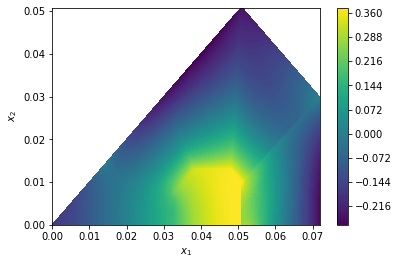

In [45]:
x,y = np.meshgrid(np.linspace(-1,1,100),np.linspace(-1,1,100))
ys = np.concatenate((x.flatten()[:,None],y.flatten()[:,None]),1)
xy1 = geom1(ys)
xy2 = geom2(ys)
xy3 = geom3(ys)
xy4 = geom4(ys)

u1 = model.solution1(weights, ys).reshape(x.shape)
u2 = model.solution2(weights, ys).reshape(x.shape)
u3 = model.solution3(weights, ys).reshape(x.shape)
u4 = model.solution4(weights, ys).reshape(x.shape)

plt.figure()
ax = plt.gca()
plt.contourf(xy1[:,0].reshape(x.shape), xy1[:,1].reshape(x.shape), u1, levels = 100, vmin = min([u1.min(),u2.min(),u3.min(),u4.min()]), vmax = max([u1.max(),u2.max(),u3.max(),u4.max()]))
plt.contourf(xy2[:,0].reshape(x.shape), xy2[:,1].reshape(x.shape), u2, levels = 100, vmin = min([u1.min(),u2.min(),u3.min(),u4.min()]), vmax = max([u1.max(),u2.max(),u3.max(),u4.max()]))
plt.contourf(xy3[:,0].reshape(x.shape), xy3[:,1].reshape(x.shape), u3, levels = 100, vmin = min([u1.min(),u2.min(),u3.min(),u4.min()]), vmax = max([u1.max(),u2.max(),u3.max(),u4.max()]))
plt.contourf(xy4[:,0].reshape(x.shape), xy4[:,1].reshape(x.shape), u4, levels = 100, vmin = min([u1.min(),u2.min(),u3.min(),u4.min()]), vmax = max([u1.max(),u2.max(),u3.max(),u4.max()]))
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.savefig('solution_pinn.eps')

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.334e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.536e-10 (tol = 1.000e-10) r (rel) = 1.152e-10 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.
Building point search tree to accelerate distance queries.
Computed bounding box tree with 802457 nodes for 401229 points.
0.48146813445827064


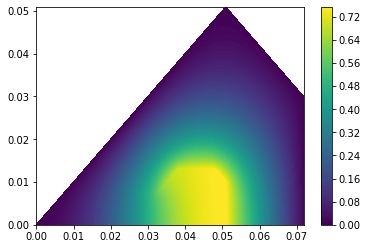

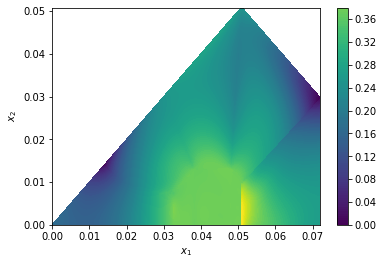

In [46]:
fem = FEM(mu0=model.mu0,mur=model.mur,J0 = model.J0,meshsize = 0.00025)

u1_ref = fem.call_A(xy1[:,0],xy1[:,1]).reshape(x.shape)
u2_ref = fem.call_A(xy2[:,0],xy2[:,1]).reshape(x.shape)
u3_ref = fem.call_A(xy3[:,0],xy3[:,1]).reshape(x.shape)
u4_ref = fem.call_A(xy4[:,0],xy4[:,1]).reshape(x.shape)

plt.figure()
ax = plt.gca()
plt.contourf(xy1[:,0].reshape(x.shape), xy1[:,1].reshape(x.shape), u1_ref, levels = 100, vmin = min([u1_ref.min(),u2_ref.min(),u3_ref.min(),u4_ref.min()]), vmax = max([u1_ref.max(),u2_ref.max(),u3_ref.max(),u4_ref.max()]))
plt.contourf(xy2[:,0].reshape(x.shape), xy2[:,1].reshape(x.shape), u2_ref, levels = 100, vmin = min([u1_ref.min(),u2_ref.min(),u3_ref.min(),u4_ref.min()]), vmax = max([u1_ref.max(),u2_ref.max(),u3_ref.max(),u4_ref.max()]))
plt.contourf(xy3[:,0].reshape(x.shape), xy3[:,1].reshape(x.shape), u3_ref, levels = 100, vmin = min([u1_ref.min(),u2_ref.min(),u3_ref.min(),u4_ref.min()]), vmax = max([u1_ref.max(),u2_ref.max(),u3_ref.max(),u4_ref.max()]))
plt.contourf(xy4[:,0].reshape(x.shape), xy4[:,1].reshape(x.shape), u4_ref, levels = 100, vmin = min([u1_ref.min(),u2_ref.min(),u3_ref.min(),u4_ref.min()]), vmax = max([u1_ref.max(),u2_ref.max(),u3_ref.max(),u4_ref.max()]))
plt.colorbar()

delta1 = np.abs(u1-u1_ref)
delta2 = np.abs(u2-u2_ref)
delta3 = np.abs(u3-u3_ref)
delta4 = np.abs(u4-u4_ref)

plt.figure()
ax = plt.gca()
plt.contourf(xy2[:,0].reshape(x.shape), xy2[:,1].reshape(x.shape), delta2, levels = 100, vmin = min([delta1.min(),delta2.min(),delta3.min(),delta4.min()]), vmax = max([delta1.max(),delta2.max(),delta3.max(),delta4.max()]))
plt.contourf(xy3[:,0].reshape(x.shape), xy3[:,1].reshape(x.shape), delta3, levels = 100, vmin = min([delta1.min(),delta2.min(),delta3.min(),delta4.min()]), vmax = max([delta1.max(),delta2.max(),delta3.max(),delta4.max()]))
plt.contourf(xy4[:,0].reshape(x.shape), xy4[:,1].reshape(x.shape), delta4, levels = 100, vmin = min([delta1.min(),delta2.min(),delta3.min(),delta4.min()]), vmax = max([delta1.max(),delta2.max(),delta3.max(),delta4.max()]))
plt.contourf(xy1[:,0].reshape(x.shape), xy1[:,1].reshape(x.shape), delta1, levels = 100, vmin = min([delta1.min(),delta2.min(),delta3.min(),delta4.min()]), vmax = max([delta1.max(),delta2.max(),delta3.max(),delta4.max()]))
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.savefig('error_pinn.eps')
print(max([np.max(delta1),np.max(delta2),np.max(delta3),np.max(delta4)]))

In [47]:
xs1 = geom1(model.points['ys1'])
xs2 = geom2(model.points['ys2'])
xs3 = geom3(model.points['ys3'])
xs4 = geom4(model.points['ys4'])

u1_ref = fem.call_A(xs1[:,0],xs1[:,1]).flatten()
u2_ref = fem.call_A(xs2[:,0],xs2[:,1]).flatten()
u3_ref = fem.call_A(xs3[:,0],xs3[:,1]).flatten()
u4_ref = fem.call_A(xs4[:,0],xs4[:,1]).flatten()

u1 = model.solution1(weights, model.points['ys1']).flatten()
u2 = model.solution2(weights, model.points['ys2']).flatten()
u3 = model.solution3(weights, model.points['ys3']).flatten()
u4 = model.solution4(weights, model.points['ys4']).flatten()

int1 = jnp.dot((u1-u1_ref)**2,model.points['omega1']*model.points['ws1']) / jnp.dot((u1_ref)**2,model.points['omega1']*model.points['ws1'])
int2 = jnp.dot((u2-u2_ref)**2,model.points['omega2']*model.points['ws2']) / jnp.dot((u2_ref)**2,model.points['omega2']*model.points['ws2'])
int3 = jnp.dot((u3-u3_ref)**2,model.points['omega3']*model.points['ws3']) / jnp.dot((u3_ref)**2,model.points['omega3']*model.points['ws3'])
int4 = jnp.dot((u4-u4_ref)**2,model.points['omega4']*model.points['ws4']) / jnp.dot((u4_ref)**2,model.points['omega4']*model.points['ws4'])

print(int1, int2, int3, int4)


0.9065453592846263 0.7493047890876832 0.2850730011909343 0.7264566242380331


In [48]:
print(np.mean(delta1)/np.max(u1))
print('Surface copper', np.sum(model.points['omega3']*model.points['ws3']))
print('J0 ',50/np.sum(model.points['omega3']*model.points['ws3'])*24)

0.7040767118066598
Surface copper 0.00021773911666236802
J0  5511182.457218982


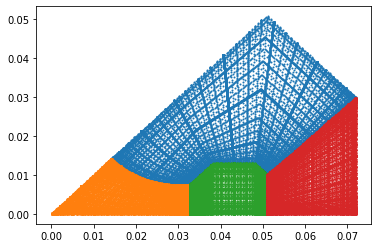

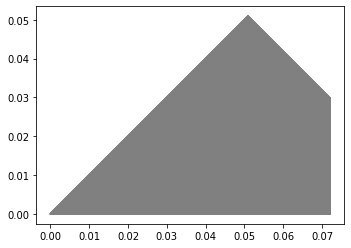

In [49]:
plt.figure()
plt.scatter(xs1[:,0],xs1[:,1], s= 1)
plt.scatter(xs2[:,0],xs2[:,1], s= 1)
plt.scatter(xs3[:,0],xs3[:,1], s= 1)
plt.scatter(xs4[:,0],xs4[:,1], s= 1)

plt.figure()
fn.plot(fem.mesh)

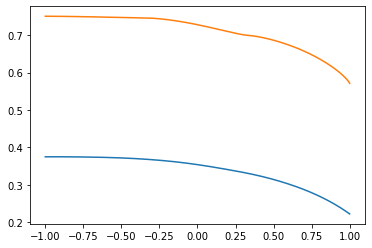

In [50]:
plt.figure()
t = np.linspace(-1,1,1000).reshape([-1,1])
plt.plot(t.flatten(),model.solution3(weights,np.concatenate((t*0+1,t),-1)))

xy = geom3(np.concatenate((t*0+1,t),-1))
plt.plot(t.flatten(),fem.call_A(xy[:,0],xy[:,1]))

In [51]:
model.points['ys1'].max(), np.sum(model.points['ys1'][:,1]*model.points['ws1'])
jax.devices()[0]

GpuDevice(id=0, process_index=0)